# Face Recognition Project

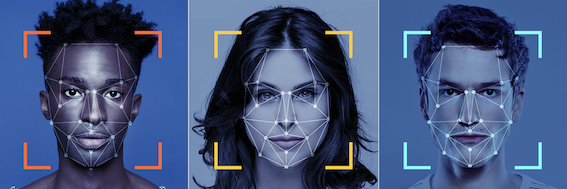

## Постановка задачи

Допустим, вы владеете компанией и хотите разработать систему распознавания лиц, чтобы применять ее в своем офисе. Например, чтобы ваши сотрудники могли сканировать лицо вместо прикладывания id карточек к турникетам при входе. Или для обеспечения безопасности в офисах (да, вы — хороший владелец компании, и используете face recognition только для обеспечения безопасности. Никакие данные не собираете, нигде долго не храните и никуда не передаете)  

Получается, вам нужна система, которая может принимать на вход видео, полученное с камер наблюдения, и на выходе выдавать, что за люди были замечены на этом видео. Ваша система должна уметь работать в случаях, когда лица людей запечатлены крупным или мелким планом, когда они чуть повернуты или наклонены, и когда на одном кадре с камеры находятся несколько лиц людей.

Вот решением такой задачи мы сейчас и займемся.

#### Распознавание лиц

Что такое "распознавание": мы хотим построить такую нейросеть, которая принимает на вход картинку лица, а выдает вектор определенного размера. И мы хотим, чтобы векторы лиц одного и того же человека были близки по некоторому расстоянию (например, косинусному), а векторы лиц разных людей были далеки по этому же расстоянию. Обычно в качестве расстояния используется [косинусное расстояние](https://en.wikipedia.org/wiki/Cosine_similarity) (cosine distance).

Почему мы хотим построить именно такую сеть? Почему не посмтроить обычную сеть для классификации и научить ее классифицировать лица из обучающей выборки, где каждый отдельный человек — это один класс? Ответ такой — мы хотим, чтобы наша модель умела работать с лицами людей, которых нет в обучающей выборке. Хотим, чтобы она на лица одного и того же незнакомого человека выдавала близкие векторы (т.е. "говорила" нам, что это один и тот же человек), а на лица разных людей — далекие векторы.

Пусть тогда у нас есть база данных людей вида (id, набор векторов его лиц). Когда к нам придет новая картинка лица, мы ее прогоним через модель и получим вектор этого лица. Далее сравним этот вектор по метрике расстояния с векторами из нашей базы. Тот id, чьи векторы будут наиболее близки к нашему, и будет ответом на вопрос "кто изображен на картинке"



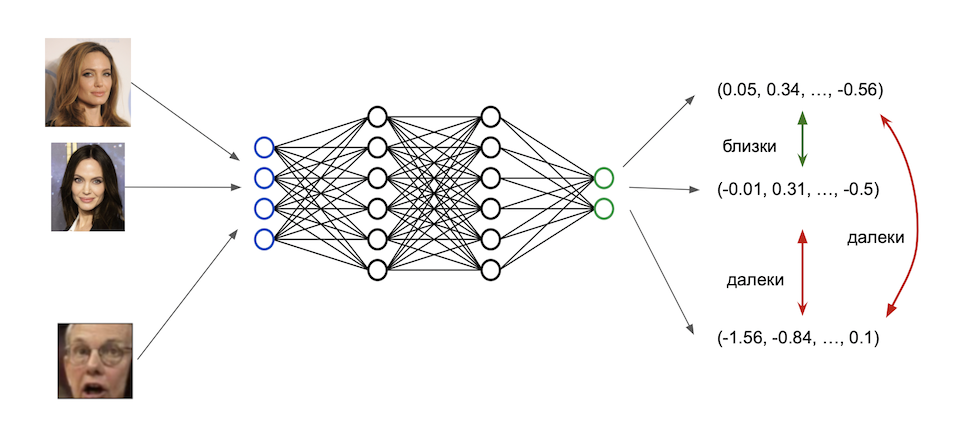

Такую сеть можно обучать разными способами. Два самых распространенных — такие:

1. Можно обучить нейросеть на обучающей выборке лиц на задачу классификации. Каждый отдельный человек — это один класс. В качестве лосс-функции можно использовать стандартную кросс-энтропию или специальные ее модификации (разберем ниже в ноутбуке). Затем, после обучения сети, выкинуть последний слой и считать вектором лица выход предпоследнего слоя сети. Это будет работать: полученные таким образом векторы лиц действительно будут близки для лиц одного и того же человека, и далеки для лиц разных людей. Причем это будет работать даже на тех лицах, которые не было в обучающей выборке (при условии, что обучающая выборка достаточно велика).

    У этого подхода есть недостаток: классов в обучающем датасете может быть очень много. Из-за этого последний слой сети станет очень широким. Это сделает обучение сети вычислительно затратным и сложным по памяти. Иногда приходится этот последний слой делить на несколько разных GPU, настолько он бывает большим.
2.  Можно пойти другим путем: обучать сеть напрямую на задачу "выдавать похожие эмбеддинги для лиц одного и того же человека, и далекие эмбеддинги для лиц разных людей". Это называется **contrastive training**.
    
    На каждой итерации обучения тогда происходит следующее:
    - берется картинка лица, к ней выбирается позитивная пара (еще одна картинка лица того же человека) и негативная (картинка лица другого человека). Все три картинки подаются на вход сети, на выходе получаются три вектора. Далее считается расстояние между векторами 1 и 2 и расстояние между векторами 1 и 3. Нейросеть обучается так, чтобы расстояние между векторами 1 и 2 было как можно меньше, а расстояние между векторами 1 и 3 — как можно больше.

#Что делаем?

Для начала обучим нейросеть для распознования лиц с помощью CrossEntropyLoss.

Будем использовать данные из датасета CelebA-500.

Возьмем нейросеть ResNet, предобученую на ImageNet.

In [ ]:
import pickle
import os
import numpy as np
from skimage import io
import pandas as pd

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler
import torch.nn as nn
from torchvision import datasets, models, transforms
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
import PIL
print(PIL.__version__)

9.4.0


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
!unzip -q /content/gdrive/MyDrive/celebA_train_500.zip

In [ ]:
!ls celebA_train_500

Предобработка данных

---



In [ ]:
train_labels = {}
test_labels = {}
val_labels = {}
slit = {}
annote = {}

with open('celebA_train_500/celebA_train_split.txt') as file:
    for string in file:
        img, id = string.split()
        slit[img] = int(id)

with open('celebA_train_500/celebA_anno.txt') as file:
    for string in file:
        img, id = string.split()
        annote[img] = int(id)

In [ ]:
files = list(os.walk(os.path.join('celebA_train_500/celebA_imgs')))[0][2]
for i in range(len(files)):
    if files[i] in annote:
        if slit[files[i]] == 0:
            train_labels[files[i]] = annote[files[i]]
        if slit[files[i]] == 1:
            val_labels[files[i]] = annote[files[i]]
        if slit[files[i]] == 2:
            test_labels[files[i]] = annote[files[i]]

train_labels = pd.DataFrame(list(train_labels.items()), columns = ['img', 'label'])
val_labels = pd.DataFrame(list(val_labels.items()), columns = ['img', 'label'])
test_labels = pd.DataFrame(list(test_labels.items()), columns = ['img', 'label'])
train_labels.head()

,img,label
0,067819.jpg,430
1,103956.jpg,8
2,030591.jpg,232
3,023207.jpg,232
4,029940.jpg,250


In [ ]:
class HumanDataset(Dataset):
    def __init__(self, img_labels : pd.DataFrame, img, transform=None):
        self.img = img
        self.img_labels = img_labels
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img, self.img_labels.iloc[idx, 0])
        image = np.array(Image.open(img_path))
        image = Image.fromarray(image[77:-41, 45:-50])
        if self.transform:
            image = self.transform(image)
        label = int(self.img_labels.iloc[idx, 1])
        return image, label

In [ ]:
transform = {
            "train": transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((160,160)),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
            "val": transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            transforms.Resize((160,160))
        ])
        }

train_dataset = HumanDataset(train_labels, 'celebA_train_500/celebA_imgs', transform["train"])
val_dataset = HumanDataset(val_labels, 'celebA_train_500/celebA_imgs', transform["val"])
test_dataset = HumanDataset(test_labels, 'celebA_train_500/celebA_imgs', transform["val"])

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


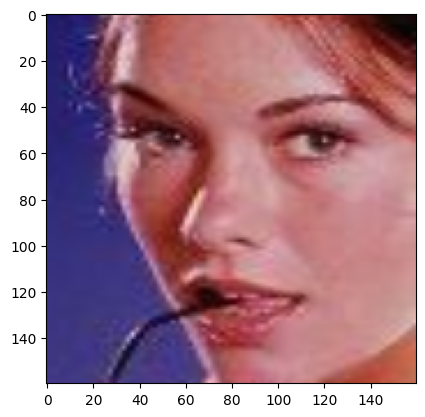

In [ ]:
random_characters = int(np.random.uniform(0,100))
im_val = val_dataset[random_characters]
imshow(im_val[0])

In [ ]:
batch_size = 64

data_tr = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
data_val = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
data_test = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Функция трейна, описание модели и само обучение

In [ ]:
def train(model, opt, scheduler, loss_fn, data_tr, data_val,epochs):
    history_loss = []
    for epoch in range(epochs):
        print('* Epoch %d/%d' % (epoch+1, epochs))
        running_corrects = 0
        processed_data = 0
        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device) # data to device
            opt.zero_grad() # set parameter gradients to zero
            Y_pred = model(X_batch) # forward-pass
            loss = loss_fn(Y_pred, Y_batch)
            loss.backward()  # backward-pass
            opt.step()  # update weights
            preds = torch.argmax(Y_pred, 1)
            running_corrects += torch.sum(preds == Y_batch).item() # calculate acc
            processed_data += len(Y_batch)
            avg_loss += loss / len(data_tr) # calculate loss
        scheduler.step()
        print('loss: %f' % avg_loss)
        history_loss.append(avg_loss.item())
        train_acc = running_corrects / processed_data
        print("train_acc =", train_acc)
        # calculate val acc
        running_corrects = 0
        processed_data = 0
        model.eval()
        for X_batch, Y_batch in data_val:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device) # data to device
            with torch.no_grad():
              Y_pred = model(X_batch)
            preds = torch.argmax(Y_pred, 1)
            running_corrects += torch.sum(preds == Y_batch).item() # calculate acc
            processed_data += len(Y_batch)

        val_acc = running_corrects / processed_data
        print("val_acc =", val_acc)

    return history_loss

In [ ]:
model_extractor = models.resnet18(pretrained=True)

n_classes = 500

# Заменяем Fully-Connected слой на наш линейный классификатор
model_extractor.fc = nn.Linear(model_extractor.fc.in_features, n_classes)

model_extractor = model_extractor.to(device)

# используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

optimizer = optim.AdamW(model_extractor.parameters(), lr=0.0003, weight_decay=0.1)

# Умножает learning_rate на 0.4 каждые 3 эпохи
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.4)
#print(model_extractor)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 142MB/s]


In [ ]:
history = train(model_extractor, optimizer, exp_lr_scheduler, loss_fn, data_tr, data_val, epochs=10)

* Epoch 1/10
loss: 5.362800
train_acc = 0.10124063670411985
val_acc = 0.2614483493077742
* Epoch 2/10
loss: 2.924461
train_acc = 0.5269194756554307
val_acc = 0.4989350372736954
* Epoch 3/10
loss: 1.289448
train_acc = 0.8531132958801498
val_acc = 0.6166134185303515
* Epoch 4/10
loss: 0.351990
train_acc = 0.9882958801498127
val_acc = 0.7289669861554846
* Epoch 5/10
loss: 0.145204
train_acc = 0.9990636704119851
val_acc = 0.731629392971246
* Epoch 6/10
loss: 0.082081
train_acc = 0.9998829588014981
val_acc = 0.7353567625133121
* Epoch 7/10
loss: 0.056521
train_acc = 1.0
val_acc = 0.7396166134185304
* Epoch 8/10
loss: 0.049925
train_acc = 1.0
val_acc = 0.739084132055378
* Epoch 9/10
loss: 0.044012
train_acc = 1.0
val_acc = 0.7396166134185304
* Epoch 10/10
loss: 0.039186
train_acc = 1.0
val_acc = 0.7401490947816827


Получили качество на валидации 0.74, теперь проверим на тесте

In [ ]:
# calculate test acc
running_corrects = 0
processed_data = 0
model_extractor.eval()
for X_batch, Y_batch in data_test:
    X_batch = X_batch.to(device)
    Y_batch = Y_batch.to(device)
    with torch.no_grad():
        Y_pred = model_extractor(X_batch)
    preds = torch.argmax(Y_pred, 1)
    running_corrects += torch.sum(preds == Y_batch).item()
    processed_data += len(Y_batch)
test_acc = running_corrects / processed_data
print("test_acc =", test_acc)

test_acc = 0.7438640654499685


# Identificaton rate metric (TPR@FPR)

При обучении модели для распознавания лиц с помощью CE (кросс-энтропии) мы можем считать метрику accuracy как индикатор того, насколько хорошо наша модель работает. Но у accuracy тут есть недостаток: она не сможет померить, насколько хорошо наша модель работает на лицах людей, которых нет в обучающей выборке.  

Чтобы это исправить, придумали новую метрику: **identification rate**. Вот как она работает:

Создадим два набора изображений лиц: query и distractors. Никакие лица из этих наборов не должны содержаться в обучающем и валидационном датасете.

1. посчитаем косинусные расстояния между лицами, соответствующими одним и тем же людям из query части. Например, пусть одному человеку соответствуют три фото в query: 01.jpg, 02.jpg, 03.jpg. Тогда считаем три косинусных расстояния между всеми тремя парами из этих фото.
2. посчитаем косинусные расстояния между лицами, соответствующими разным людям из query части.
3. посчитаем косинусные расстояния между всеми парами лиц из query и distractors. Т.е. пара — это (лицо из query, лицо из distractors). Всего получится |query|*|distractors| пар.
4. Сложим количества пар, полученных на 2 и 3 шагах. Это количество false пар.
5. Зафиксируем **FPR** (false positive rate). Пусть, например, будет 0.01. FPR, умноженный на количество false пар из шага 4 — это разрешенное количество false positives, которые мы разрешаем нашей модели. Обозначим это количество через N.
6. Отсортируем все значения косинусных расстояний false пар. N — ое по счету значение расстояния зафиксируем как **пороговое расстояние**.
7. Посчитаем количество positive пар с шага 1, которые имеют косинусное расстояние меньше, чем пороговое расстояние. Поделим это количество на общее количество positive пар с шага 1. Это будет TPR (true positive rate) — итоговое значение нашей метрики.

Такая метрика обычно обозначается как TPR@FPR=0.01. FPR может быть разным. Приразных FPR будет получаться разное TPR.

Смысл этой метрики в том, что мы фиксируем вероятность ошибки вида false positive, т.е. когда "сеть сказала, что это один и тот же человек, но это не так", считаем порог косинусного расстояния для этого значения ошибки, потом берем все positive пары и смотрим, у скольких из них расстояние меньше этого порога. Т.е. насколько точно наша сеть ищет похожие лица при заданной вероятности ошибки вида false positive.

In [ ]:
!unzip -q /content/gdrive/MyDrive/celebA_ir.zip

In [ ]:
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity

# file with query part annotations: which image belongs to which class
# format:
#     image_name_1.jpg 2678
#     image_name_2.jpg 2679

f = open('./celebA_ir/celebA_anno_query.csv', 'r')
query_lines = f.readlines()[1:]
f.close()
query_lines = [x.strip().split(',') for x in query_lines]
# plain list of image names from query. Neede to compute embeddings for query
path_query = './celebA_ir/celebA_query/{}'
query_img_names = [path_query.format(x[0]) for x in query_lines]

# dictionary with info of which images from query belong to which class
# format:
#     {class: [image_1, image_2, ...]}
query_dict = defaultdict(list)
for img_name, img_class in query_lines:
  query_dict[img_class].append(img_name)

# list of distractor images
path_distractors = './celebA_ir/celebA_distractors/{}'
distractors_img_list = os.listdir('./celebA_ir/celebA_distractors')
distractors_img_names = [path_distractors.format(x) for x in distractors_img_list]

In [ ]:
class celebAIrDataset(Dataset):
    def __init__(self, images_list, transform):
        self.images = images_list
        self.transform = transform

    def get_tensors(self):
        images = torch.stack([self.transform(Image.open(img_name)) for img_name in self.images])
        return images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img = Image.open(img_name)

        return self.transform(img), idx

In [ ]:
def compute_embeddings(model, images_list):
  '''
  compute embeddings from the trained model for list of images.
  params:
    model: trained nn model that takes images and outputs embeddings
    images_list: list of images paths to compute embeddings for
  output:
    list: list of model embeddings. Each embedding corresponds to images
          names from images_list
  '''
  dataset = celebAIrDataset(images_list, transform["train"])
  model.to(device)
  data_emb = DataLoader(dataset.get_tensors(), batch_size=batch_size, shuffle=False)
  model.eval()
  emb = []
  for X_batch in data_emb:
    X_batch = X_batch.to(device)
    with torch.no_grad():
      Y_pred = model(X_batch)
    emb.append(Y_pred.cpu())
  return torch.cat(emb)

In [ ]:
query_embeddings = compute_embeddings(model_extractor, query_img_names)
distractors_embeddings = compute_embeddings(model_extractor, distractors_img_names)

In [ ]:
def compute_cosine_query_pos(query_dict, query_img_names, query_embeddings):
  '''
  compute cosine similarities between positive pairs from query (stage 1)
  params:
    query_dict: dict {class: [image_name_1, image_name_2, ...]}. Key: class in
                the dataset. Value: images corresponding to that class
    query_img_names: list of images names
    query_embeddings: list of embeddings corresponding to query_img_names
  output:
    list of floats: similarities between embeddings corresponding
                    to the same people from query list
  '''
  emb = torch.Tensor()
  for pers_class in query_dict:
    if query_dict[pers_class][0] in query_img_names:
      path = '{}'
    else:
      path = './celebA_ir/celebA_query/{}'


  for pers_class in query_dict:
    img = []
    for obj in query_dict[pers_class]:
      img.append(path.format(obj))
    local_emb = []
    for paths in img:
      local_emb.append(torch.Tensor(query_embeddings[query_img_names.index(paths)]))
    if len(local_emb) != 0:
      dist = cosine_similarity(np.array(torch.stack(local_emb)), np.array(torch.stack(local_emb)))
      table = pd.DataFrame(dist)
      table = table.mask(np.tril(np.ones(table.shape, dtype=np.bool_))).values.reshape(-1)
      result = table[~np.isnan(table)]
      result = torch.Tensor(result).view(-1)
      emb = torch.cat((emb, result))
    else:
      local_emb = torch.Tensor()
      dist = 0.0
  res = [x.item() for x in emb]
  return res



def compute_cosine_query_neg(query_dict, query_img_names, query_embeddings):
  '''
  compute cosine similarities between negative pairs from query (stage 2)
  params:
    query_dict: dict {class: [image_name_1, image_name_2, ...]}. Key: class in
                the dataset. Value: images corresponding to that class
    query_img_names: list of images names
    query_embeddings: list of embeddings corresponding to query_img_names
  output:
    list of floats: similarities between embeddings corresponding
                    to different people from query list
  '''
  emb = torch.Tensor()
  classes = []

  for pers_class in query_dict:
    if query_dict[pers_class][0] in query_img_names:
      path = '{}'
    else:
      path = './celebA_ir/celebA_query/{}'

  for pers_class in query_dict:
    img = []
    for obj in query_dict[pers_class]:
      img.append(path.format(obj))
    classes.extend([pers_class for i in range(len(img))])
    local_emb = []
    for paths in img:
      local_emb.append(torch.Tensor(query_embeddings[query_img_names.index(paths)]))
    if len(local_emb) != 0:
      emb = torch.cat((emb, torch.stack(local_emb)))
    else:
      local_emb = torch.Tensor() #()
      dist = 0.0

  dist = cosine_similarity(emb, emb)
  dist =  pd.DataFrame(data=dist, index=classes, columns=classes)

  for i in dist:
      dist.loc[i, i] = np.nan

  triangle = dist.mask(np.tril(np.ones(dist.shape, dtype=np.bool_))).values.reshape(-1)
  res = triangle[~np.isnan(triangle)]
  return res



def compute_cosine_query_distractors(query_embeddings, distractors_embeddings):
  '''
  compute cosine similarities between negative pairs from query and distractors
  (stage 3)
  params:
    query_embeddings: list of embeddings corresponding to query_img_names
    distractors_embeddings: list of embeddings corresponding to distractors_img_names
  output:
    list of floats: similarities between pairs of people (q, d), where q is
                    embedding corresponding to photo from query, d —
                    embedding corresponding to photo from distractors
  '''
  dist = cosine_similarity(query_embeddings, distractors_embeddings).reshape(-1)
  return dist


In [ ]:
cosine_query_pos = compute_cosine_query_pos(query_dict, query_img_names,
                                            query_embeddings)
cosine_query_neg = compute_cosine_query_neg(query_dict, query_img_names,
                                            query_embeddings)
cosine_query_distractors = compute_cosine_query_distractors(query_embeddings,
                                                            distractors_embeddings)


И, наконец, финальная функция, которая считает IR metric:

In [ ]:
def compute_ir(cosine_query_pos, cosine_query_neg, cosine_query_distractors,
               fpr=0.1):
  cosine_query_pos = torch.Tensor(cosine_query_pos)
  cosine_query_neg = torch.Tensor(cosine_query_neg)
  cosine_query_distractors = torch.Tensor(cosine_query_distractors)

  false_pairs = torch.cat((cosine_query_neg, cosine_query_distractors))
  count = round(fpr * len(false_pairs))
  false_pairs = torch.sort(false_pairs, descending = True)[0]
  threshold = false_pairs[count]
  TPR = len(cosine_query_pos[cosine_query_pos > threshold]) / len(cosine_query_pos)
  return threshold.item(), TPR

А в ячейке ниже посчитаем TPR@FPR для датасета с лицами. Давайте, например, посчитаем для значений fpr = [0.5, 0.2, 0.1, 0.05].

In [ ]:
fpr = [0.5, 0.2, 0.1, 0.05]
TPR = []

for i in fpr:
  x, y = compute_ir(cosine_query_pos, cosine_query_neg, cosine_query_distractors, fpr=i)
  TPR.append(y)
print(TPR)

[0.9893349636573603, 0.8841111337545003, 0.7517831669044223, 0.6094694653895795]


#ArcFace loss

В случае с обучением на задачу классификации лосс-функция, которая нам приходит в голову — Cross-Entropy. И на нее действительно можно обучать сеть для распознавания лиц. Но за много лет люди придумали более хитрые лосс-функции, которые делают обучение сети для распознавания лиц более эффективным. Одним из лучших считается ArcFace Loss (Additive Angular Margin Loss).

Этот лосс — чуть измененная кросс-энтропия. Он позволяет достичь лучшего распределения векторов лиц на сфере. В нем добавлены некоторые дополнительные ограничения и гиперпараметры, для того чтобы эмбеддинги лиц одного класса были более близки между собой, а эмбеддинги лиц разных людей оставались далеки. То есть, этот лосс позволяет лучше кластеризовать лица на сфере единичного радиуса.


**Как устроен ArcFace**:

Стандартные SoftMax + кросс-энтропия (CE) выглядят так:

$$L_{CE} = \frac{-1}{N}\sum_1^N \frac{e^{W_{y_i}^{T}x_i + b_{y_i}}}{\sum^n_{j=1}e^{W_j^Tx_i+b_j}},$$

здесь:
- $x_i \in \mathbb{R^d}$ — вектор $i$-го элемента обучающей выборки перед последним полносвязным слоем сети. $y_i$ — класс этого элемента;
- $W_j \in \mathbb{R^d}$ — j-ый столбец матрицы весов последнего слоя сети (т.е. слоя, который производит итоговую классификацю входящего объекта);
- $b_j \in \mathbb{R^d}$ — j-ый элемент вектора байеса последнего слоя сети;
- $N$ — batch size;
- $n$ — количество классов.


Хотя этот лосс работает хорошо, он явным образом не заставляет эмбеддинги $x_i$ элементов, принадлежащих одному классу, быть близкими друг к другу по расстоянию. И не заставляет эмбеддинги элементов, принадлежащих разным классам, быть далеко друг от друга. Все, что хочет этот лосс — чтобы на основе эмбеддингов $x_i$ можно было хорошо классифицировать элементы, никакие ограничений на расстояния между эмбеддингами $x_i$ он не вводит.

Из-за этого у нейросетей для распознавания лиц, которые обучены на обычном CE loss, бывают проблемы с распознаванием лиц, которые сильно отличаются от лиц того же человека разными допатрибутами (шляпа/прическа/очки и т.п.). Просто эмбеддинг для таких лиц получается довольно далек по расстоянию от других эмбеддингов лиц этого же человека.

Давайте теперь немного поправим формулу:
- уберем байес последнего слоя, т.е. сделаем $b_j=0$;
- нормализуем веса последнего слоя: ||$W_j$|| = 1;
- нормализуем эмбеддинги: ||$x_i$|| = 1. Перед подачей их на вход последнему слою (т.е. перед умножением на матрицу $W_j$) умножим их на гиперпараметр s. По сути, мы приводим норму всех эмбеддингов к s. Смысл этого гиперпараметра в том, что, возможно, сети проще будет классифицировать эмбеддинги, у которых не единичная норма.

Нормализация эмбеддингов приводит к тому, что эмбеддинги начинают быть распределены по сфере единичного радиуса (и сфере радиуса s после умножения на ниперпараметр s). И итоговые предсказания сети после последнего слоя зависят только от угла между эмбеддингами $x_i$ и выученных весов $W_j$. От нормы эмбеддинга $x_i$ они больше не зависят, т.к. у всех эмбеддингов они теперь одинаковые.

Получается, в степени экспоненты у нас останется выражение $s W_{y_i}^{T}x_i$, которое можно переписать в виде  $s W_{y_i}^{T}x_i = s ||W_{y_i}||\cdot ||x_i|| \cdot cos\Theta_{y_i}$. Тут $\Theta_{y_i}$ — это угод между векторами $W_{y_i}$ и $x_i$. Но так как мы сделали нормы $W_{y_i}$ и $x_i$ единичными, то все это выражение просто будет равно $s cos\Theta_{y_i}$.

В итоге мы получим следующую формулу лосса:

$$L = \frac{-1}{N}\sum_1^N \frac{e^{s\ cos\Theta_{y_i}}}{e^{s\ cos\Theta_{y_i}} + \sum^n_{j=1,\ j\ne y_i} e^{s\ cos\Theta_j}}$$


И последний шаг. Добавим еще один гиперпараметр $m$. Он называется additive angular margin penalty и заставляет эмбеддинги одного класса быть ближе друг к другу, а эмбеддинги разных классов — более далекими друг от друга.

В итоге получим вот что:

$$L_{ArcFace} = \frac{-1}{N}\sum_1^N \frac{e^{s\ cos(\Theta_{y_i} + m)}}{e^{s\ cos(\Theta_{y_i} + m)} + \sum^n_{j=1,\ j\ne y_i} e^{s\ cos\Theta_j}}$$

Это и есть ArcFace Loss с двумя  гиперпараметрами, s и m.

Получается, что ArcFace Loss завтавляет сеть выучивать эмбеддинги, распределенные по сфере радиуса s, причем чтобы эмбеддинги одного класса были ближе друг к другу, а эмбеддинги разных классов — более далеки друг от друга.



In [ ]:
import torch.nn.functional as F

In [ ]:
class ArcFace_Layer(nn.Module):
  def __init__(self, in_f, out_f, s=20.0, m=0.5):
    super(ArcFace_Layer, self).__init__()
    self.s = s
    self.m = m
    self.fc = nn.Linear(in_f, out_f, bias=False)
    self.eps = 1e-5

  def forward(self, logits, labels):
    for weights in self.fc.parameters():
        weights = F.normalize(weights) # Нормализуем веса

    X = F.normalize(logits)  # Нормализуем эмбеддинги
    Y = self.fc(X)   # Проходим через линейный слой

    upper = self.s * torch.cos(torch.acos(torch.clamp(torch.diagonal(Y.transpose(0, 1)[labels]), -1.+self.eps, 1-self.eps)) + self.m) # Считаем степень верхней экспоненты

    excl = torch.cat([torch.cat((Y[i, : j], Y[i, j+1 : ])).unsqueeze(0) for i, j in enumerate(labels)], dim=0)
    denominator = torch.exp(upper) + torch.sum(torch.exp(self.s * excl), dim=1) # Считаем знаменатель

    L = upper - torch.log(denominator) # Логарифмируем и вычисляем итоговое значение
    return -torch.mean(L)

  def pred(self, x):
    preds = self.fc(x)
    return preds

In [ ]:
def train_arcface(model, opt, scheduler, loss_fn, data_tr, data_val,epochs):
    history_loss = []
    loss_opt = torch.optim.AdamW(loss_fn.parameters(), lr=0.0003)
    for epoch in range(epochs):
        print('* Epoch %d/%d' % (epoch+1, epochs))
        running_corrects = 0
        processed_data = 0
        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device) # data to device

            opt.zero_grad() # set parameter gradients to zero
            loss_opt.zero_grad()

            Y_pred = model(X_batch)
            loss = loss_fn.forward(Y_pred, Y_batch) # forward-pass

            loss.backward()  # backward-pass

            opt.step()  # update weights
            loss_opt.step()

            preds = loss_fn.pred(Y_pred)
            preds = torch.argmax(preds, 1)
            running_corrects += torch.sum(preds == Y_batch).item() # calculate acc
            processed_data += len(Y_batch)
            avg_loss += loss / len(data_tr) # calculate loss
        scheduler.step()
        print('loss: %f' % avg_loss)
        history_loss.append(avg_loss.item())
        train_acc = running_corrects / processed_data
        print("train_acc =", train_acc)
        # calculate val acc
        running_corrects = 0
        processed_data = 0
        model.eval()
        for X_batch, Y_batch in data_val:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device) # data to device
            with torch.no_grad():
              Y_pred = model(X_batch)
              preds = loss_fn.pred(Y_pred)
            preds = torch.argmax(preds, 1)
            running_corrects += torch.sum(preds == Y_batch).item()
            processed_data += len(Y_batch)

        val_acc = running_corrects / processed_data
        print("val_acc =", val_acc)

    return history_loss

In [ ]:
Arcface_model = models.resnet18(pretrained=True)

n_classes = 512

# Заменяем Fully-Connected слой на наш линейный классификатор
Arcface_model.fc = nn.Linear(Arcface_model.fc.in_features, n_classes)

Arcface_model = Arcface_model.to(device)

loss_fn = ArcFace_Layer(512, 500, s=15, m=0.01).to(device)

# Обучаем только классификатор
optimizer = optim.AdamW(Arcface_model.parameters(), lr=0.0003, weight_decay=0.1)

# Умножает learning_rate на 0.4 каждые 3 эпохи
arcface_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.4)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
history = train_arcface(Arcface_model, optimizer, arcface_lr_scheduler, loss_fn, data_tr, data_val, epochs=10)

* Epoch 1/10


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


loss: 5.633671
train_acc = 0.09176029962546817
val_acc = 0.22417465388711394
* Epoch 2/10
loss: 3.632020
train_acc = 0.4850187265917603
val_acc = 0.4579339723109691
* Epoch 3/10
loss: 1.895397
train_acc = 0.8312265917602997
val_acc = 0.6230031948881789
* Epoch 4/10
loss: 0.572111
train_acc = 0.9812734082397003
val_acc = 0.739084132055378
* Epoch 5/10
loss: 0.197050
train_acc = 0.9983614232209738
val_acc = 0.7476038338658147
* Epoch 6/10
loss: 0.096803
train_acc = 0.9998829588014981
val_acc = 0.7513312034078807
* Epoch 7/10
loss: 0.060942
train_acc = 0.9997659176029963
val_acc = 0.7539936102236422
* Epoch 8/10
loss: 0.046008
train_acc = 1.0
val_acc = 0.751863684771033
* Epoch 9/10
loss: 0.036516
train_acc = 1.0
val_acc = 0.7550585729499467
* Epoch 10/10
loss: 0.029346
train_acc = 1.0
val_acc = 0.7561235356762513


In [ ]:
running_corrects = 0
processed_data = 0
Arcface_model.eval()
for X_batch, Y_batch in data_test:
    X_batch = X_batch.to(device)
    Y_batch = Y_batch.to(device)
    with torch.no_grad():
        Y_pred = Arcface_model(X_batch)
        preds = loss_fn.pred(Y_pred)
    preds = torch.argmax(preds, 1)
    running_corrects += torch.sum(preds == Y_batch).item()
    processed_data += len(Y_batch)
test_acc = running_corrects / processed_data
print("test_acc =", test_acc)

test_acc = 0.7444933920704846


Получилось качество на тесте 0.74 при использовании ArcFace loss